In [1]:
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Import packages for visualization of results
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV
# Iport packages for evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
df_1 = pd.read_csv(r"C:\Users\flore\OneDrive\Documents\CSUN\Fall24\COMP_541\Project\VideoGame\games.csv")

In [3]:
df_2 = pd.read_csv(r"C:\Users\flore\OneDrive\Documents\CSUN\Fall24\COMP_541\Project\VideoGame\all_games.csv")

In [4]:
df_1.columns = ['Name','Release date','Estimated Owners','Peak CCU','Required age','Price','Unknown1',
              'Unknown2','About the game','Supported languages','Full audio languages','Reviews','Header Image','Website',
              'Support url','Support email','Windows','Mac', 'Linux','User score','Metacritic url'
              ,'Positive','Negative','Score rank','Achievements','Recommendations','Unknown3','Notes',
              'Average playtime forever','Average playtime two weeks','Median playtime forever','Median playtime two weeks',
              'Developers','Publishers','Categories','Genres','Tags','Screenshots','Movies']

In [5]:
df_2.columns = ['Name','Platform','Release Date','Summary','Meta Score','User Review']

In [6]:
df_1 = df_1.drop(['Developers','Average playtime forever','Average playtime two weeks','Median playtime forever','Median playtime two weeks','Recommendations','Estimated Owners','About the game','Reviews','Unknown1','Unknown2','Unknown3', 'Supported languages','Full audio languages','Header Image' ,'Website', 'Support url', 'Support email', 'Notes', 'Metacritic url', 'Achievements', 'Screenshots', 'Movies','Publishers','Categories','Tags'], axis=1)

In [7]:
df_2 = df_2.drop(['Summary','Release Date','Platform'], axis=1)

In [8]:
df_1 = df_1.dropna()
df_2 = df_2.dropna()

In [9]:
new_dataset = pd.merge(df_1, df_2, on='Name', how='inner')

In [10]:
new_dataset['Release date'] = new_dataset['Release date'].str.extract(r'(\d{4})')
new_dataset['Release date'] = pd.to_numeric(new_dataset['Release date'], errors='coerce')
new_dataset = new_dataset[new_dataset['Release date'] >= 2014]

In [11]:
new_dataset['Genres'] = new_dataset['Genres'].str.split(',')
unique_tags = set(tag for sublist in new_dataset['Genres'] for tag in sublist)
one_hot_encoded_genres = new_dataset['Genres'].str.join('|').str.get_dummies()
new_dataset = pd.concat([new_dataset, one_hot_encoded_genres], axis=1)
new_dataset.drop('Genres', axis=1, inplace=True) #don't need 'Genres' feature any more

In [12]:
unique_ages = new_dataset['Required age'].unique()
print(unique_ages)

[ 0 13 17 18 16 10 12  1]


In [13]:
new_dataset['Required age'] = new_dataset['Required age'].replace({1:0,10:0,12:0})
new_dataset['Required age'] = new_dataset['Required age'].replace({13:1,16:1})
new_dataset['Required age'] = new_dataset['Required age'].replace({17:2,18:2})

In [14]:
new_dataset = new_dataset.drop(['Name'], axis = 1)

In [15]:
new_dataset['User Review'] = new_dataset['User Review'].replace('tbd', np.nan)
new_dataset['User Review'] = pd.to_numeric(new_dataset['User Review'], errors='coerce')
new_dataset = new_dataset.dropna(subset=['User Review'])

In [16]:
Q1 = new_dataset['Negative'].quantile(0.25)
Q3 = new_dataset['Negative'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
new_dataset = new_dataset[(new_dataset['Negative'] >= lower_bound) & (new_dataset['Negative'] <= upper_bound)]

In [17]:
new_dataset.shape

(3603, 34)

In [18]:
y =new_dataset['User Review']

In [19]:
X = new_dataset.drop(['User Review'], axis=1)

In [20]:
X = pd.DataFrame(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3
)

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [23]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [24]:
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, np.ravel(y_train))

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [25]:
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(scaler.transform(X_test))

In [26]:
min_value = min(min(y_test), min(y_pred_best))
max_value = max(max(y_test), max(y_pred_best))

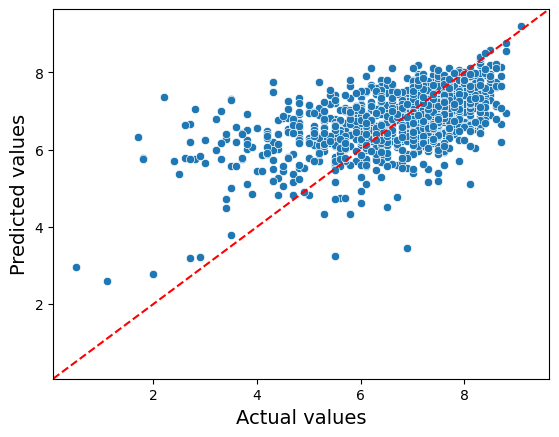

In [27]:
p = sns.scatterplot(x=y_test, y=y_pred_best)
p.set_xlabel("Actual values", fontsize=14)
p.set_ylabel("Predicted values", fontsize=14)
plt.axline((min_value,min_value), (max_value, max_value), color='r', ls='--')

In [28]:
print("MSE: ", metrics.mean_squared_error(y_test, y_pred_best))
print("MAE: ", metrics.mean_absolute_error(y_test, y_pred_best))
print("R sqaure: ", metrics. r2_score(y_test, y_pred_best))

MSE:  1.2459292635038008
MAE:  0.8462119476270603
R sqaure:  0.28932102020165384
